In [ ]:
%tensorflow_version 1.x

!pip install tensorboardcolab

In [ ]:
%matplotlib inline
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import decimal
import datetime as dt
from tensorboardcolab import * 

In [ ]:
colors = [None, 'r', 'g', 'b', 'm', 'y', 'k']
lambdas = [0, 0.001, 0.01,  0.1,  1,  10,  100]

df = pd.read_csv('full_data.csv')
df = df[df.location == "Serbia"]
df = df.loc[(df['date'] <= '2020-10-21')]
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].map(dt.datetime.toordinal)

params = [val for val in df.columns.values if val !='date' and val !='location']
print(params)

['new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'weekly_cases', 'weekly_deaths', 'biweekly_cases', 'biweekly_deaths']


['new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'weekly_cases', 'weekly_deaths', 'biweekly_cases', 'biweekly_deaths']
Wait for 8 seconds...
TensorBoard link:
https://355841c8c974.ngrok.io
w =  [ 0.02630469 -0.27095363 -0.00423475] bias =  0.24039659 lambda =  0
w =  [ 0.02627425 -0.27088383 -0.00422785] bias =  0.24034218 lambda =  0.001
w =  [ 0.02600162 -0.27025566 -0.00416635] bias =  0.23985326 lambda =  0.01
w =  [ 0.0234167  -0.26411033 -0.00360255] bias =  0.23505665 lambda =  0.1
w =  [ 0.007308   -0.2139902  -0.00136017] bias =  0.19518577 lambda =  1
w =  [-0.01258393 -0.07069185 -0.01053519] bias =  0.07308796 lambda =  10
w =  [-0.01584247 -0.01797529 -0.01680138] bias =  0.029801784 lambda =  100


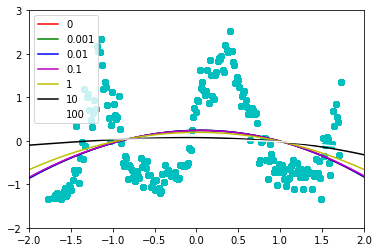

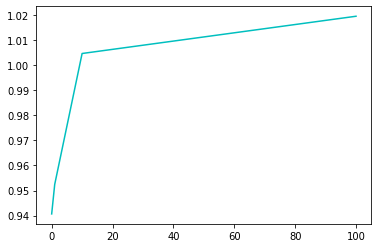

In [ ]:
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)

colors = [None, 'r', 'g', 'b', 'm', 'y', 'k', 'w']

df = pd.read_csv('full_data.csv')
df = df[df.location == "Serbia"]
df = df.loc[(df['date'] <= '2020-10-21')]
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].map(dt.datetime.toordinal)

params = [val for val in df.columns.values if val !='date' and val !='location']
print(params)
# df.plot(x="date", y='new_cases', kind="scatter")


tf.reset_default_graph()

nb_features = 3
plot2_x = []
plot2_y = []
for idx, lmbd in enumerate(lambdas):
  y = df['new_cases'].to_numpy()
  nb_samples = len(y)
  x = df['date'].to_numpy()

  x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
  y = (y - np.mean(y)) / np.std(y)
  plt.scatter(x, y, color='c')
  x = create_feature_matrix(x, nb_features)

  X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32, name='X')
  Y = tf.placeholder(shape=(None), dtype=tf.float32, name='Y')
  w = tf.Variable(tf.zeros(nb_features), name='W')
  bias = tf.Variable(0.0, name='bias')

  w_col = tf.reshape(w, (nb_features, 1))
  hyp = tf.add(tf.matmul(X, w_col), bias)
  Y_col = tf.reshape(Y, (-1, 1))

  l2_reg = lmbd * tf.reduce_mean(tf.square(w))
  l1_reg = lmbd * tf.reduce_mean(tf.abs(w))

  mse = tf.reduce_mean(tf.square(hyp - Y_col), name='mse')
  loss = tf.add(mse, l2_reg, name='loss')
  opt_op = tf.train.AdamOptimizer().minimize(loss)

  if idx == 0:
    tbc = TensorBoardColab()
    writer = tbc.get_writer()
    writer.add_graph(tf.get_default_graph())
    writer.flush()

  nb_epochs = 300
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(nb_epochs):
      epoch_loss = 0
      for sample in range(nb_samples):
        feed = {X: x[sample].reshape((1, nb_features)), 
                Y: y[sample]}
        _, curr_loss = sess.run([opt_op, mse], feed_dict=feed)
        epoch_loss += curr_loss
          
      epoch_loss /= nb_samples
      if (epoch + 1) % 100 == 0:
        print('Epoch: {}/{}| Avg loss: {:.5f}'.format(epoch+1, nb_epochs, 
                                                epoch_loss))
    
    plot2_x.append(lmbd)
    plot2_y.append(epoch_loss)
    w_val = sess.run(w)
    bias_val = sess.run(bias)
    print('w = ', w_val, 'bias = ', bias_val, 'lambda = ', lmbd)
    xs = create_feature_matrix(np.linspace(-2, 4, 100), nb_features)
    hyp_val = sess.run(hyp, feed_dict={X: xs})
    plt.plot(xs[:, 0].tolist(), hyp_val.tolist(), color=colors[1 + idx], label=str(lmbd))
    plt.xlim([-2, 2])
    plt.ylim([-2, 3])
plt.legend(loc="upper left")
plt.show()
plt.plot(plot2_x, plot2_y, color='c')
plt.show()

# Mozemo da primetimo da kako raste lambda tako raste i loss.
# Trenutna funkcija sa stepenom 3 nije dovoljno dobra da "fituje" podatke, pa regularizacija nema toliko smisla.
# U modelu imamo veci "bias" od "variance", koji moze da se resi tako sto nadjemo neku bolju funkciju.
# Da smo imali veci "variance" od "bias", tada bi regularizacija imala smisla.